# Homework #9 (Due 11/20/2019, 11:59pm)
## Sequential Data and Kalman Filtering

**AM 207: Advanced Scientific Computing**<br>
**Instructor: Weiwei Pan**<br>
**Fall 2019**

**Name:**

**Students collaborators:**

### Instructions:

**Submission Format:** Use this notebook as a template to complete your homework. Please intersperse text blocks (using Markdown cells) amongst `python` code and results -- format your submission for maximum readability. Your assignments will be graded for correctness as well as clarity of exposition and presentation -- a “right” answer by itself without an explanation or is presented with a difficult to follow format will receive no credit.

**Code Check:** Before submitting, you must do a "Restart and Run All" under "Kernel" in the Jupyter or colab menu. Portions of your submission that contains syntactic or run-time errors will not be graded.

**Libraries and packages:** Unless a problems specifically asks you to implement from scratch, you are welcomed to use any `python` library package in the standard Anaconda distribution.

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp
import pandas as pd

In [146]:
# plot configs
%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.style.use("fivethirtyeight")

## Problem Description: Kalman Filters for Sequential Data
In Lecture #19, we've argued that by assuming linear dynamics for both the state and observation models and by assuming Gaussian noise, we can inductively infer the distribution $p(X_n|Y_{1:n})$ -- i.e. the distribution over the true state at time $n$, $X_n$, given observations $Y_{1}, \ldots, Y_{n}$. In this homework, you will explore the properties of Kalman filters (what are the design choices, how do they impact your estimate of $p(X_n|Y_{1:n})$?) when applied to data generated by linear Gaussian models (LGMs) and also when they are applied to data generated by non-LGMs.

Recall that the general form of a 1-D linear Gaussian model is given by

\begin{align}
&X_0 \sim \mathcal{N}(0, \Sigma) \quad \mathbf{(Initial\; Distribution)}\\
&X_{n+1} = aX_n + b + c\xi,\;\; \xi\sim \mathcal{N}(0, 1) \quad \mathbf{(State\;Model)}\\
&Y_{n+1} = dX_{n+1} + e + f\epsilon,\;\; \epsilon\sim \mathcal{N}(0, 1) \quad \mathbf{(Observation\;Model)}
\end{align}

where $a, b, c, d, e, f$ are scalar constants (they do not change over time).

### Part I: Properties of Linear Guassian Models

1. By empirical or theoretical analysis, qualitatively describe the types of trajectory that can be generated by the state model $X_{n+1} = aX_n + b + c\xi,\;\; \xi\sim \mathcal{N}(0, 1)$. Concretely describe the impact of each constant $a$, $b$ and $c$ on trajectories generated by this state model.<br>

2. Given a fixed state model, by empirical or theoretical analysis, qualitatively describe the distribution of $Y_n - X_n$ (the difference between observation and true state value). Concretely describe the impace of each constant $d$, $e$ and $f$ on $Y_n - X_n$.

#### 1.1 Trajectories

Let's investigate what happens to the state model when $a$ is negative, $b$ is large, and $c$ is large, respectively.

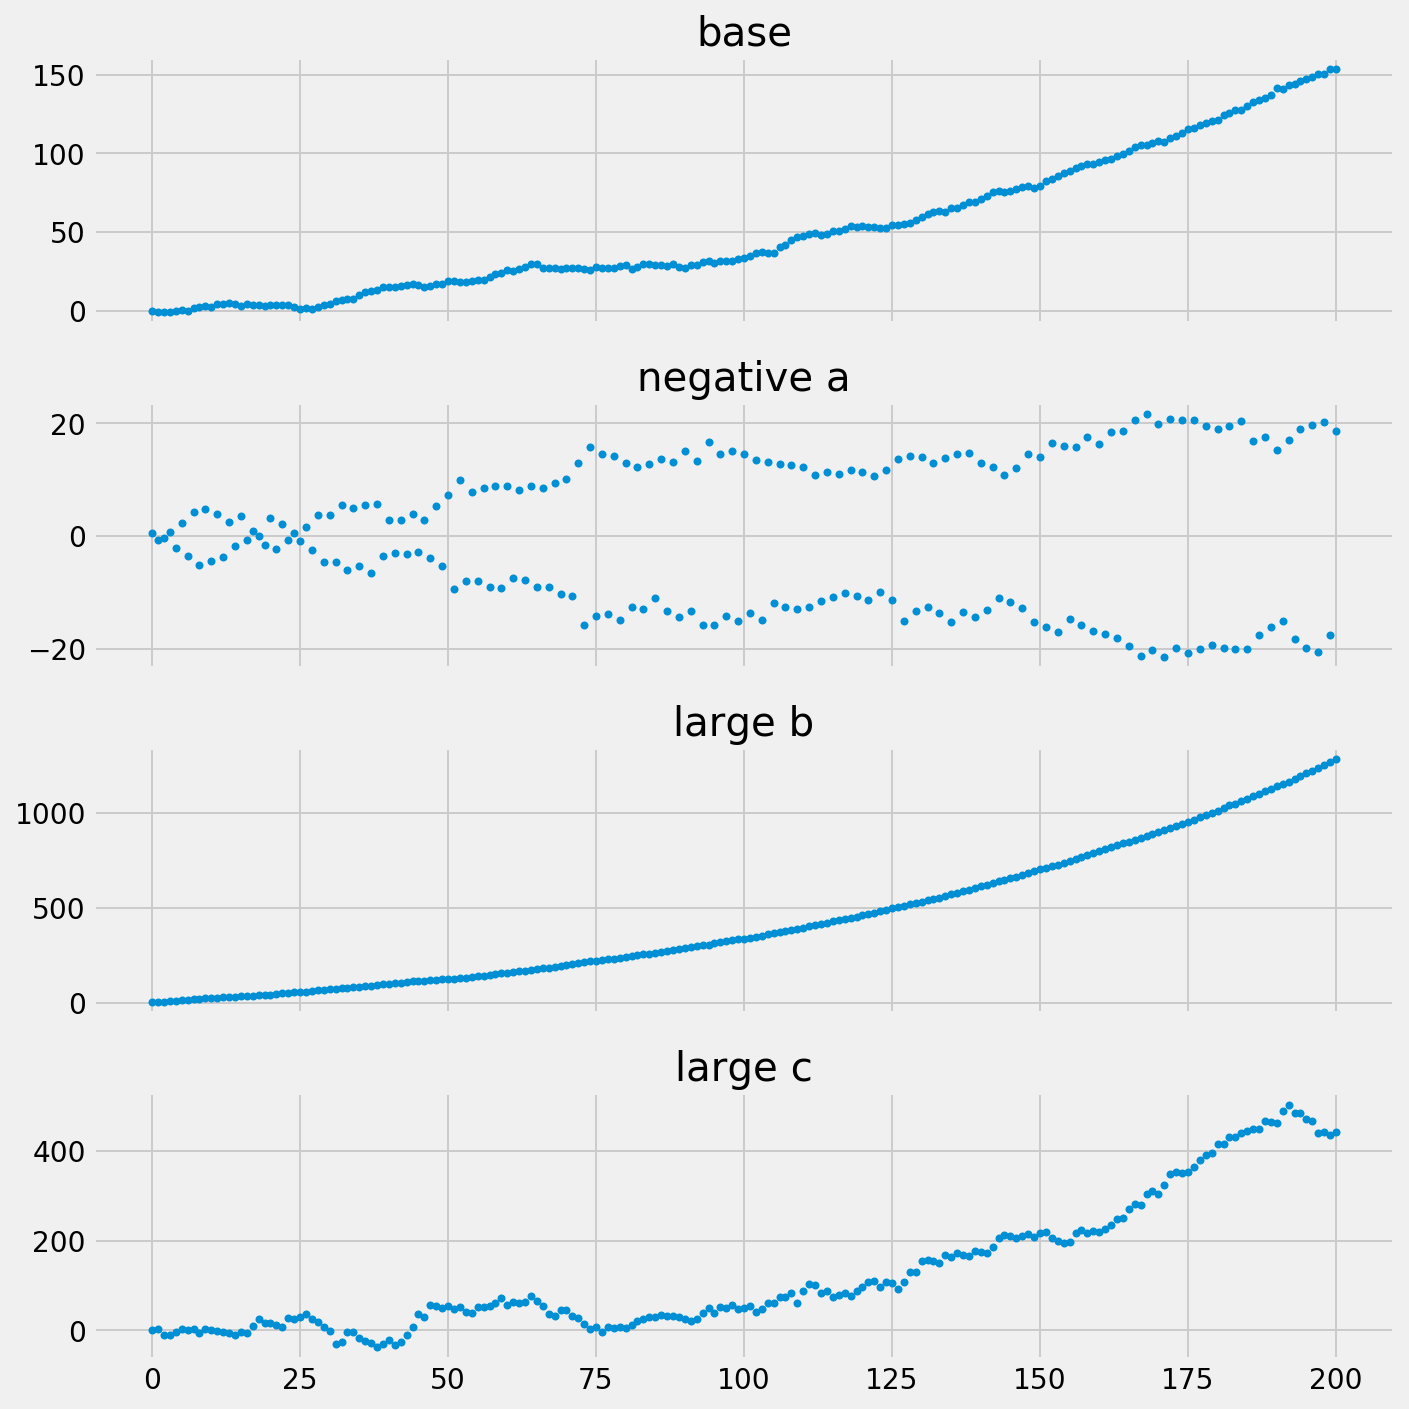

In [178]:
# calculate X_n+1 given X_n
def next_state(X_current, a, b, c):
    xi = np.random.randn()
    X_next = a*X_current + b + c*xi
    return X_next

# simulate state model for N steps
def simulate_state(N, state_params):
    X_0 = np.random.randn()
    X = [X_0]
    for n in range(N):
        X_next = next_state(X[n], **state_params)
        X.append(X_next)
    return np.array(X)

fig, axes = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

# base case
state_params = {
    'a': 1.01,
    'b': 0.2,
    'c': 1.,
}
X = simulate_state(N=200, state_params=state_params)
axes[0].plot(X, '.')
axes[0].set_title("base")

# negative a
state_params = {
    'a': -1.01,
    'b': 0.2,
    'c': 1.,
}
X = simulate_state(N=200, state_params=state_params)
axes[1].plot(X, '.')
axes[1].set_title("negative a")
    
# large b
state_params = {
    'a': 1.01,
    'b': 2.,
    'c': 1.,
}
X = simulate_state(N=200, state_params=state_params)
axes[2].plot(X, '.')
axes[2].set_title("large b")

# large c
state_params = {
    'a': 1.01,
    'b': 0.2,
    'c': 10.,
}
X = simulate_state(N=200, state_params=state_params)
axes[3].plot(X, '.')
axes[3].set_title("large c")

fig.tight_layout()

Empirically, it looks like $a$ can bifurcate our state model, $b$ controls the overal trend, and $c$ controls the spread/variance of $X$.

#### 1.2 Observation - State Model

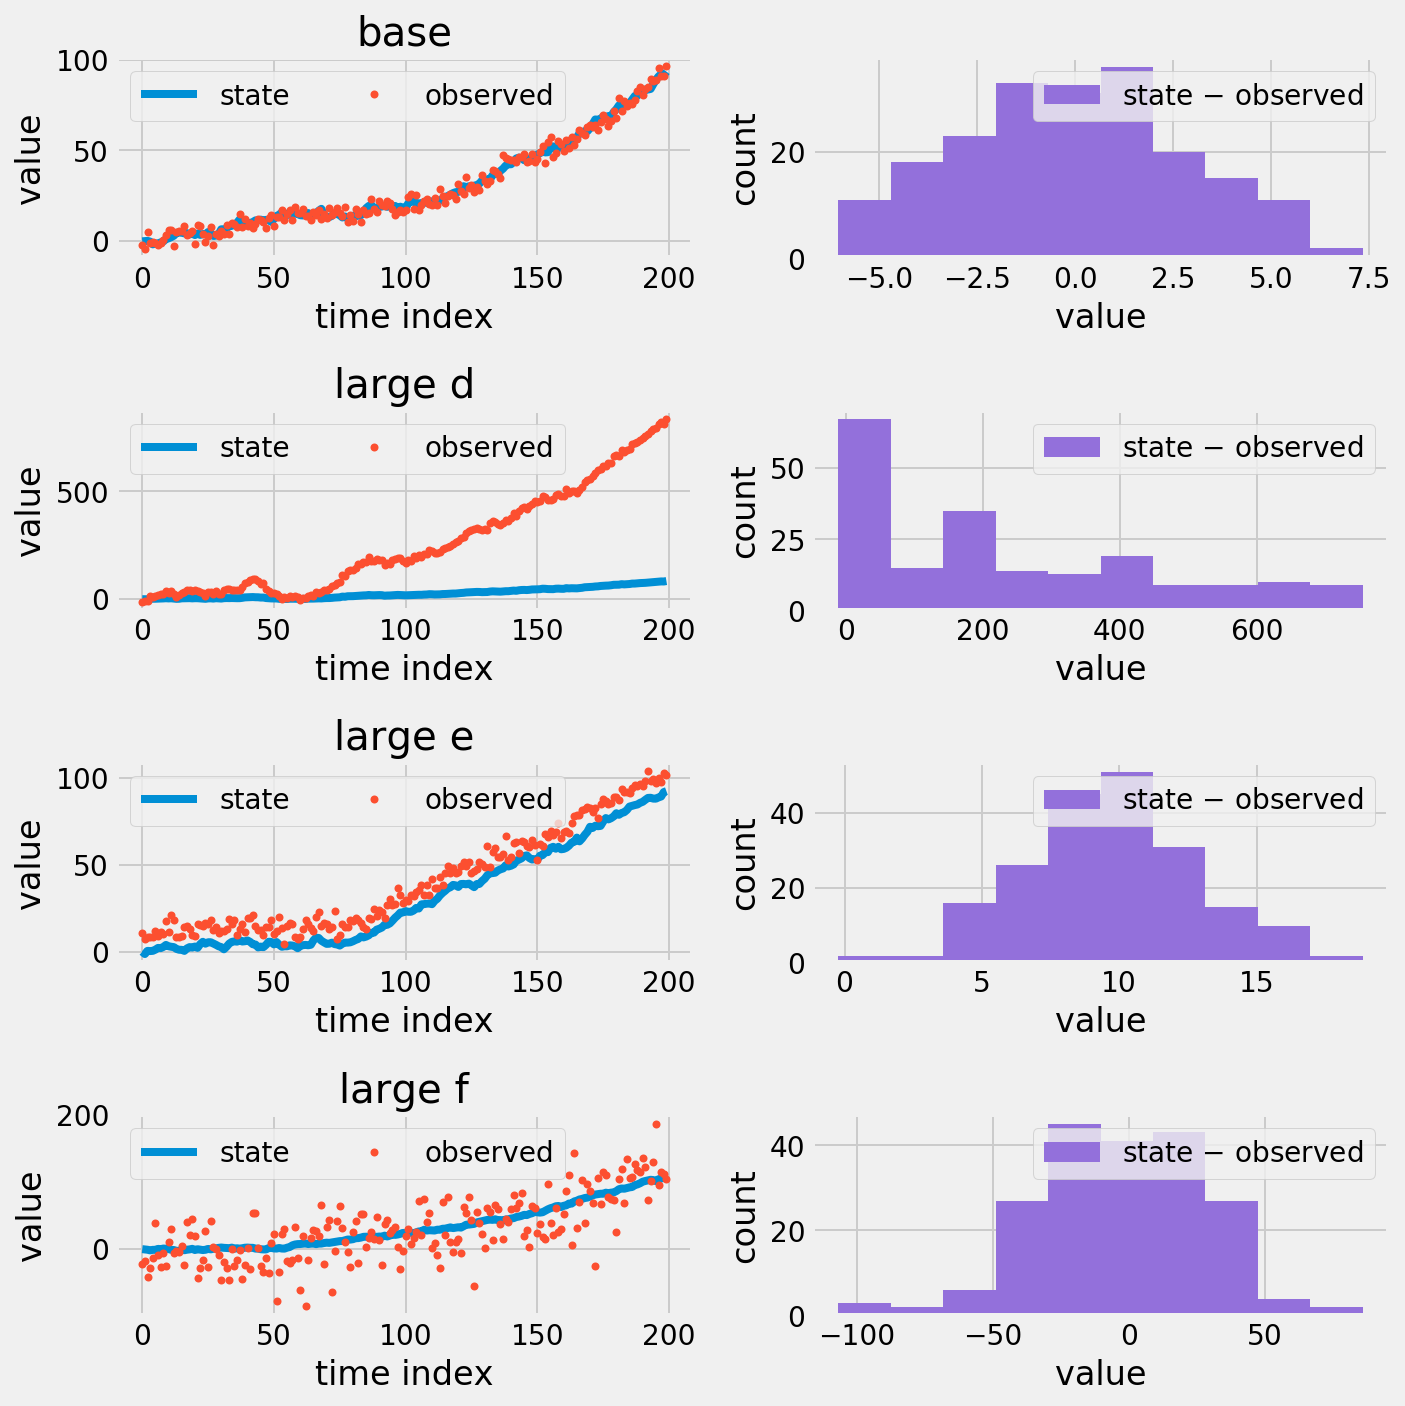

In [180]:
# calculate Y_n given X_n
def next_obs(X_current, d, e, f):
    eps = np.random.randn()
    Y_next = d*X_current + e + f*eps
    return Y_next

# simulate observation model
def simulate_obs(N, state_params, obs_params):
    X_0 = np.random.randn()
    X = [X_0]
    Y = []
    for n in range(N):
        Y_current = next_obs(X[n], **obs_params)
        X_next = next_state(X[n], **state_params)
        X.append(X_next)
        Y.append(Y_current)
    
    return np.array(X[:-1]), np.array(Y)
    
fig, axes = plt.subplots(4, 2, figsize=(10, 10))

# convenience plotter
def plot_diff(ax_row, X, Y):
    # time vs. X and Y
    ax_row[0].plot(X, label="state")
    ax_row[0].plot(Y, '.', label="observed")
    ax_row[0].legend(loc=2, ncol=2)
    ax_row[0].set_xlabel("time index")
    ax_row[0].set_ylabel("value")
    
    # time vs. Y - X
    ax_row[1].hist(Y - X, color="mediumpurple", label=r"state $-$ observed")
    ax_row[1].legend(loc=1)
    ax_row[1].set_xlabel("value")
    ax_row[1].set_ylabel("count")
    return ax_row

# keep state model fixed
state_params = {
    'a': 1.01,
    'b': 0.2,
    'c': 1.,
}

# base case
obs_params = {
    'd': 1.,
    'e': 0.,
    'f': np.sqrt(10.),
}
X, Y = simulate_obs(200, state_params, obs_params)
plot_diff(axes[0], X, Y)
axes[0, 0].set_title("base")

# large d
obs_params = {
    'd': 10.,
    'e': 0.,
    'f': np.sqrt(10.),
}
X, Y = simulate_obs(200, state_params, obs_params)
plot_diff(axes[1], X, Y)
axes[1, 0].set_title("large d")

# large e
obs_params = {
    'd': 1.,
    'e': 10.,
    'f': np.sqrt(10.),
}
X, Y = simulate_obs(200, state_params, obs_params)
plot_diff(axes[2], X, Y)
axes[2, 0].set_title("large e")

# large f
obs_params = {
    'd': 1.,
    'e': 0.,
    'f': 10*np.sqrt(10.),
}
X, Y = simulate_obs(200, state_params, obs_params)
plot_diff(axes[3], X, Y)
axes[3, 0].set_title("large f")
fig.tight_layout()

### Part II: Deriving the Kalman Filtering Algorithm
In filtering, we assume that the dynamics of the LGM is known (you've estimated $a, b, c, d, e, f$ from the data in a previous stage or these were provided to you).

**Inductive Hypothesis**: In the following, suppose we have $p(X_{n-1} | Y_{1:n-1}) = \mathcal{N}(\hat{x}_{n-1},\hat{\sigma}^2_{n-1})$.

1. (**Deriving the Prediction Step**) In the prediction step of the Kalman Filtering algorithm, we compute 
$$p(X_n | Y_{1:n-1}) = \int p(X_n|X_{n-1})p(X_{n-1}|Y_{1:n-1})dX_{n-1} = \mathcal{N}(a\hat{x}_{n-1} + b, r_{n}),$$
where $r_n = a^2 \hat{\sigma}^2_{n-1} + c^2$. Derive this formula for $p(X_n | Y_{1:n-1})$ in the Prediction Step.
<br><br>

2. (**Deriving the Update Step**) In the update step of the Kalman Filtering algorithm, we compute 

$$p(X_n| Y_{1:n}) = \frac{p(Y_t|X_t)p(X_t|Y_{1:t-1})}{p(Y_n | Y_{1:n-1})} = \mathcal{N}(\hat{x}_n, \hat{\sigma}_n),$$ 
where 
\begin{align}
\hat{x}_n &= (a\hat{x}_{n-1} + b) + K_n(y_n - (d(a\hat{x}_{n-1} + b) + e) ),\\
\hat{\sigma}_n &= r_n  (1 - K_n  d),\\
K_n &= \frac{r_n  d}{f^2 + d^2  r_n}.
\end{align}
Derive this formula for $p(X_n| Y_{1:n})$ in the Update Step.
<br><br>

#### 2.1 Deriving the Prediction Step
Subbing in the transition step for $p(X_n|X_{n-1})$ and $\mathcal{N}(\hat{x}_{n-1}, \hat{\sigma}^2_{n-1})$ for $p(X_{n-1} | Y_{1:n-1})$, we have:

$$
p(X_n | Y_{1:n-1}) \sim \int\mathcal N(aX_{n-1} + b, c^2) \cdot 
\mathcal N(\widehat x_{n-1}, \widehat\sigma_{n-1}^2) \text{ d} X_{n-1} \quad.
$$

We COULD write out the exponential form of each pdf, combine exponents, complete the square on it, pull out what doesn't depend on $x_{n-1}$, compute the closed form of the remaining Gaussian integral, combine that with what we pulled out from the integral in the previous step, re-cast the product as a normal pdf, and match moments... but that would be terrible. It's not like I filled up a few pages with algebra doing just this and am bitter about it, but it's whatever.

Instead, let's use what we now about expectation values and take advantage of the fact that we are integrating over Gaussian pdfs, like they do [here](http://ais.informatik.uni-freiburg.de/teaching/ws17/mapping/pdf/gaussian_notes.pdf). In general, what we're really doing is just getting the total probability of some quantity $y$ where:

$\newcommand{\dx}{\text{ d}x}$
$\newcommand{\dy}{\text{ d}y}$
$$
p(y) = \int_{-\infty}^{\infty} p(y|x)p(x) \dx \quad,
$$

where

\begin{align}
X \sim \mathcal N(\mu_X, \sigma_X^2) &\quad\Longrightarrow\quad
p(x) = \frac{1}{\sqrt{2\pi\sigma_X^2}}\exp
\left[-\frac{(x - \mu_X)^2}{2\sigma_X^2}\right] \\
Y|x \sim \mathcal N(ax + b, \sigma_r^2) &\quad\Longrightarrow\quad
p(y|x) = \frac{1}{\sqrt{2\pi\sigma_r^2}}\exp
\left[-\frac{(y - ax - b)^2}{2\sigma_r^2}\right] \quad.
\end{align}

In our case, $p(y) \to p(X_n|Y_{1:n-1})$, $X \to \mathcal N(\widehat x_{n-1}, \widehat\sigma_{n-1}^2)$, and $Y | x \to \mathcal N(aX_{n-1} + b, c^2)$. We want to show what the mean and variance of $y$ is then. We know the expected value of a Gaussian is it's mean, so let's start with that:

\begin{align}
\newcommand{\inti}{\int_{\infty}^{\infty}}
\mu_Y &= \mathbb E_Y[Y] = \int_{\infty}^\infty y p(y)\dy & \text{used definition of } \mathbb E \\
&= \inti y \left( \int_{-\infty}^{\infty} p(y|x)p(x) \dx \right) \dy 
& \text{subbed in } p(y) \\
&= \inti p(x) \left( \inti y p(y|x)\dy \right)\dx & \text{grouped variables} \\
&= \inti p(x) \mathbb E_{Y|x}[Y]\dx & \text{used definition of } \mathbb E \\
&= \inti p(x)(ax + b)\dx  & \text{used property of Gaussian} \\
&= a\inti xp(x)\dx + b\inti p(x)\dx & \text{separated terms} \\
&= a\mathbb E_X[X] + b & \text{used def. of } \mathbb E \text{ and def. of normalized pdfs} \\
&= a\mu_X + b & \text{used property of Gaussian} \\
&= \boxed{a \widehat x_{n-1} + b}\quad. & \text{profit}
\end{align}

Similarly, see (pg. 4 of reference above): 

$$
\sigma_Y^2 = \sigma_r^2 + a^2\sigma_X^2 = c^2 + a^2\widehat\sigma_{n-1}^2 
= \boxed{r_n} \quad.
$$

Putting it all together:

$$
\boxed{p(X_n | Y_{1:n-1}) \sim 
\mathcal N (a \widehat x_{n-1} + b, r_n)} \quad.
$$

#### 2.2 Deriving the Update Step

Now that we know $p(X_n | Y_{1:n-1})$, we can multiply it with $p(Y_n | X_x)$ (which we know from the LGM) to get the numerator of $p(X_n | Y_{1:n})$. The denominator is just a normalizing constant, so to get the actual form of this distribution we only really need to now what the sum of the exponents looks like after multiplying the exponential terms from each distribution together. Doing this, we have:

\begin{align}
&p(X_n|Y_{1:n}) \propto p(Y_n|X_n) \cdot p(X_n|Y_{1:n-1}) \sim
\mathcal N(d X_n + e, f^2) \cdot \mathcal N(a\widehat x_{n-1} + b, r_n) \\
\quad\Longrightarrow\quad
&\frac{(y_n - dx_n - e)^2}{2f^2} + \frac{(x_n - a\widehat x_{n-1} - b^2)}{2r_n}
= \frac{r_n[-dx_n+(y_n-e)]^2 + f^2[x_n-(a\widehat x_{n-1}+b)]^2}{2r_n f^2} \\
&= \frac{r_n[d^2x_n^2-2d(y_n-e)x_n+(y_n-e)^2] + f
^2[x_n^2-2(a\widehat x_{n-1}+b)x_n 
+(a\widehat x_{n-1}+b)^2]}{2 r_nf^2} \\
&= \frac{(r_nd^2+f^2)x_n^2 
+ 2[r_nd(y_n-e)+f^2(a\widehat x_{n-1}+b)]x_n
- r_n(y_n-e)^2 - f^2(a\widehat x_{n-1}+b)^2}{2r_nf^2} \quad.
\end{align}

Ok, this looks pretty gross, but we can work with it. We now that the result should be distributed like a Gaussian that goes like $\mathcal N(\widehat x_n, \widehat\sigma_n)$, so let's play the same game of expanding out its exponent and then match terms together. From the resulting Gaussian we have:

\begin{align}
\frac{(x - \widehat x_n)^2}{2\widehat\sigma_n^2} = \frac{x^2 - 2\widehat x_n x + 
\widehat x_n^2}{2\widehat\sigma_n^2}\quad.
\end{align}

We only really need to match the terms in front of $x^2$ and $x$ because the other term can just be swept into the normalizing constant. Equating just the first two gives us the following system of equations:

$$
\begin{align}
\frac{1}{2\widehat\sigma_n^2} &= \frac{r_n d^2 + f^2}{2r_nf^2} \\
\frac{\widehat x_n}{\widehat\sigma_n^2} 
&= \frac{r_nd(y_n-e) + f^2(a\widehat x_{n-1}+b)}{r_nf^2}\quad.
\end{align}
$$

Solving the equation for $\widehat\sigma_n$ first,

$$
\begin{align}
\widehat\sigma_n^2 = \frac{r_n f^2}{f^2 + r_nd^2}
= \boxed{r_n(1 - K_n d)} \quad.
\end{align}
$$

Solid. Moving on to the next (and doing a bit of algebraic gymnastics),

$$
\begin{align}
\widehat x_n &= \frac{r_nf^2}{f^2 + r_n d^2} \cdot
\frac{r_nd(y_n-e) + f^2(a\widehat x_{n-1}+b)}{r_nf^2} \\
&= \frac{r_nd(y_n-e)+f^2(a\widehat x_{n-1}+b)
+ r_nd^2(a\widehat x_{n-1}+b)
- r_nd^2(a\widehat x_{n-1}+b)}{f^2 + r_nd^2} \\
&= \frac{f^2 + r_nd^2}{f^2 + r_nd^2}(a\widehat x_{n-1}+b)
+ \frac{r_nd}{f^2 + r_nd^2}[(y_n-e) - d(a\widehat x_{n-1}+b)] \\
&= \boxed{(a\widehat x_{n-1}+b) + K_n[y_n - (d(a\widehat x_{n-1}+b)+e)]}\quad,
\end{align}
$$

where $K_n = r_n d / (f^2 + r_n d^2)$.

Putting it all together,

$$
\boxed{p(X_n| Y_{1:n}) \sim \mathcal{N}(\hat{x}_n, \hat{\sigma}_n^2)} \quad.
$$

### Part III: Properties of the Kalman Filter

1. (**The Kalman Gain**) The constant $K_n$ in the update step is called the ***Kalman gain***. Show that the Kalman gain is a number between 0 and 1 when $d> 1$. Describe the relationship between the variance of $p(X_n| Y_{1:n})$ and the value of the Kalman gain. Then describe when factors affects the value of the Kalman gain (when is the gain large? When is it small?).
<br><br>

2. (**Kalman Filter Asymptotics**) From Part II, we see that $p(X_n| Y_{1:n})$ is a Gaussian $\mathcal{N}(\hat{x}_n, \hat{\sigma}_n)$ for each $n$. By empirical or theoretical analysis, describe what happens to the mean and variance of this Gaussian as $n$ approaches infinity. Do the asymptoptic behaviours of the mean and variance depend on your choice of initialization for the Kalman filtering algorithm - if so, how? Do the asymptoptic behaviours depend on your choices of $a, b, c, d, e, f$ - if so how? 
<br><br>
  
3. (**Applying Kalman Filters Under Model Misspecification**) Apply a Kalman filter with your choices of $a, b, c, d, e, f$ to data generated from the stochastic volatility model
$$
\begin{align}
X_0 &\sim \mathcal{N}\left(0, \frac{\sigma^2}{1 - \alpha^2} \right)\\
X_{n+1} | X_n &\sim \mathcal{N}(\alpha \cdot X_{n}, \sigma^2)\\
Y_{n+1} | X_{n+1} &\sim \mathcal{N}(0, \beta^2 \cdot \mathrm{exp}(X_{n+1}))
\end{align}
$$
for $\alpha = 0.91, \sigma = 1., \beta=0.5$.

  Describe the quality of your Kalman filter fit to the observed data and the true state values. Empirically speaking, can you produce a better fit to the data by choosing $a, b, c, d, e, f$ more strategically?
<br><br>

#### 3.3 Applying Kalman Filters Under Model Misspecification

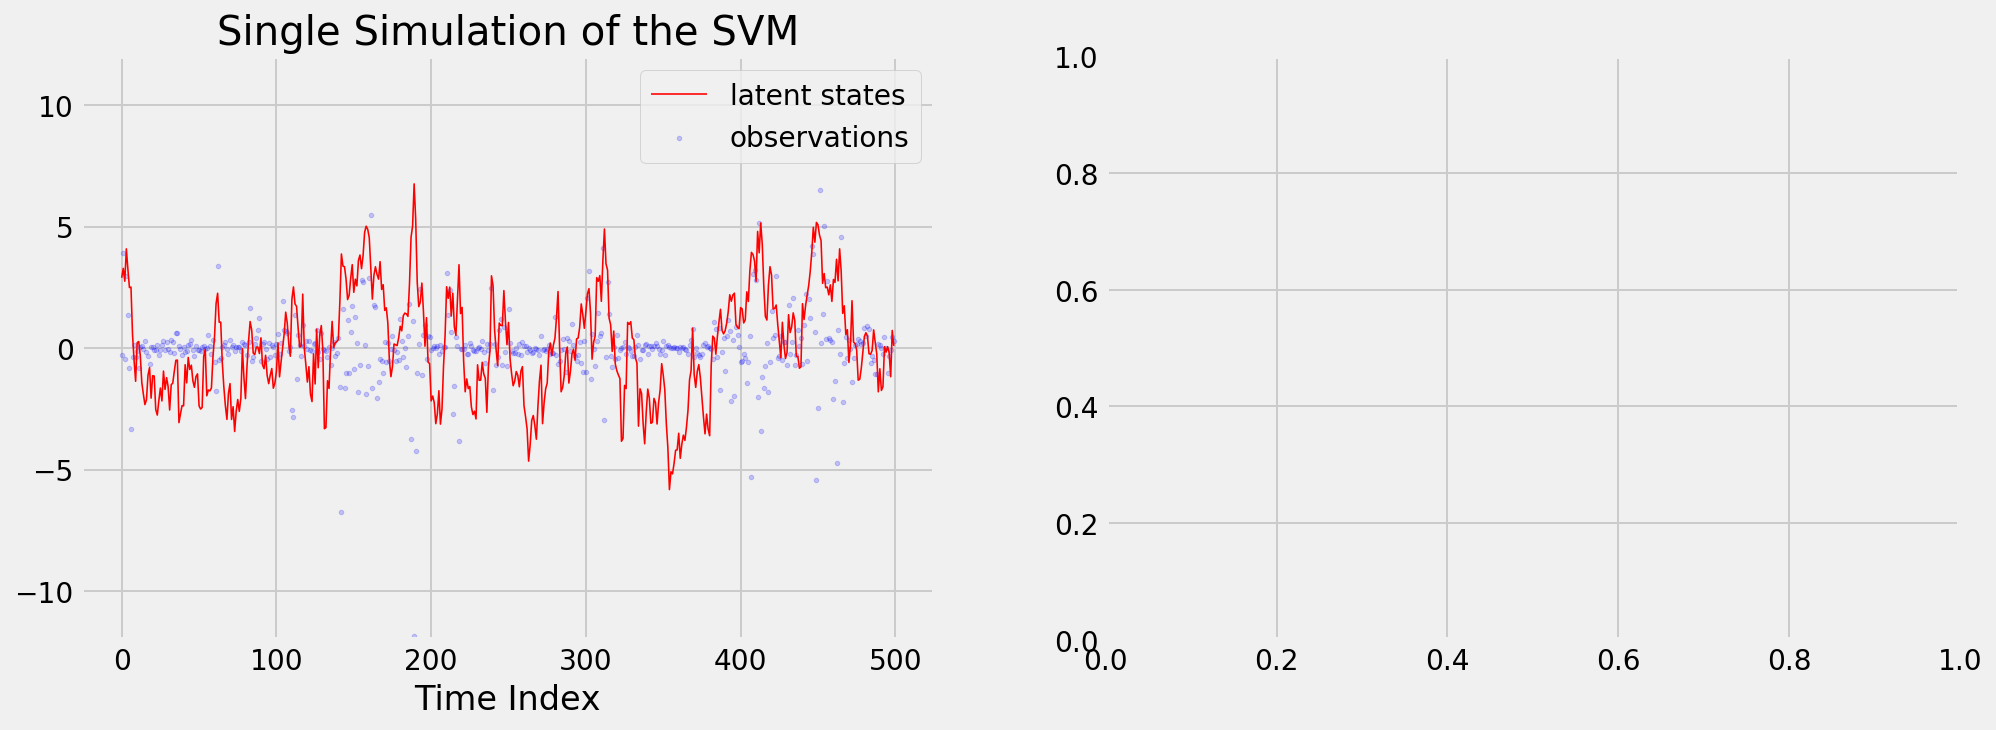

In [132]:
def kalman_filter(y, a, b, c, d, e, f, mu_init=0, sigma_init=1.):
    steps = len(y)
    x_mean_current = mu_init
    x_sigma_current = sigma_init
    x_mus = [mu_init]
    x_sigmas = [sigma_init]

    for n in range(1, steps):
        #predict step
        mu = a * x_mean_current + b 
        r = a**2 * x_sigma_current + c**2
        y_current = d * mu + e
        
        #update step
        K = r * d / (f**2 + d**2 * r)
        x_mean_next = mu + K * (y[n] - y_current)
        x_sigma_next = r * (1 - K * d)
        
        #prep for next iteration
        x_mus.append(x_mean_next[0])
        x_sigmas.append(x_sigma_next)
        
        x_mean_current = x_mean_next
        x_sigma_current = x_sigma_next
        
    return np.array(x_mus), np.array(x_sigmas)

def SVM_simulate(sigma, alpha, beta, sample_x, steps=100):
    x_current = sample_x(1)
    latent_vars = [x_current]
    observations = []
    
    for _ in range(steps):
        y_current = beta * np.exp(x_current / 2.) * np.random.normal(0, 1) 
        x_next = alpha * x_current + sigma * np.random.normal(0, 1)
        observations.append(y_current)
        latent_vars.append(x_next)
        x_current = x_next
        
    return np.array(latent_vars[:-1]), np.array(observations)

###define the parameters of the Stochastic Volatility Model

#parameters for the underlying markov process: x_n+1 = alpha * x_n + sigma * N(0, 1)
alpha = 0.91
sigma = 1.

#parameters for the observation model: y_n = beta * exp(x_n/2) * N(0, 1)
beta = 0.5

#number of time steps to simulate
steps = 500

#initial distribution over latent state space
sample_x = lambda n: np.random.normal(0, sigma**2 / (1. - alpha**2), size=n)

def plot_svm(ax):
    ###plot a single simulation: compare latent with observed

    #simulate the SVM once, for both latent and observed variables
    latent_vars, observations = SVM_simulate(sigma, alpha, beta, sample_x, steps=steps)
    #plot
    ax[0].plot(np.arange(len(latent_vars)), latent_vars, color='red', linewidth=0.8, label='latent states')
    ax[0].scatter(np.arange(len(observations)), observations, color='blue', s=5., label='observations', alpha=0.2)
    ax[0].legend(loc='best')
    ax[0].set_ylim([-12, 12])
    ax[0].set_xlabel('Time Index')
    ax[0].set_title('Single Simulation of the SVM')

    """
    ###plot multiple simulations: compare observed with the mean of observations
    simulations = 50 #number of simulations
    observation_mean = 0 #array of mean observed value for each time index

    for i in range(simulations):
        _, observations = SVM_simulate(sigma, alpha, beta, sample_x, steps=steps)
        observation_mean += observations
        if i == 0:
            ax[1].plot(np.arange(len(observations)), observations, color='blue', label='observations', alpha=0.1)
        else:
            ax[1].plot(np.arange(len(observations)), observations, color='blue', alpha=0.1)

    observation_mean /= (simulations * 1.)

    ax[1].plot(np.arange(len(observations)), observation_mean, color='black', label='observation mean', alpha=1.)
    ax[1].legend(loc='best')
    ax[1].set_ylim([-20, 20])
    ax[1].set_xlabel('Time Index')
    ax[1].set_title('Multiple Simulation of the SVM')
    """
    
    return ax

np.random.seed(42)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax = plot_svm(ax)
plt.show()

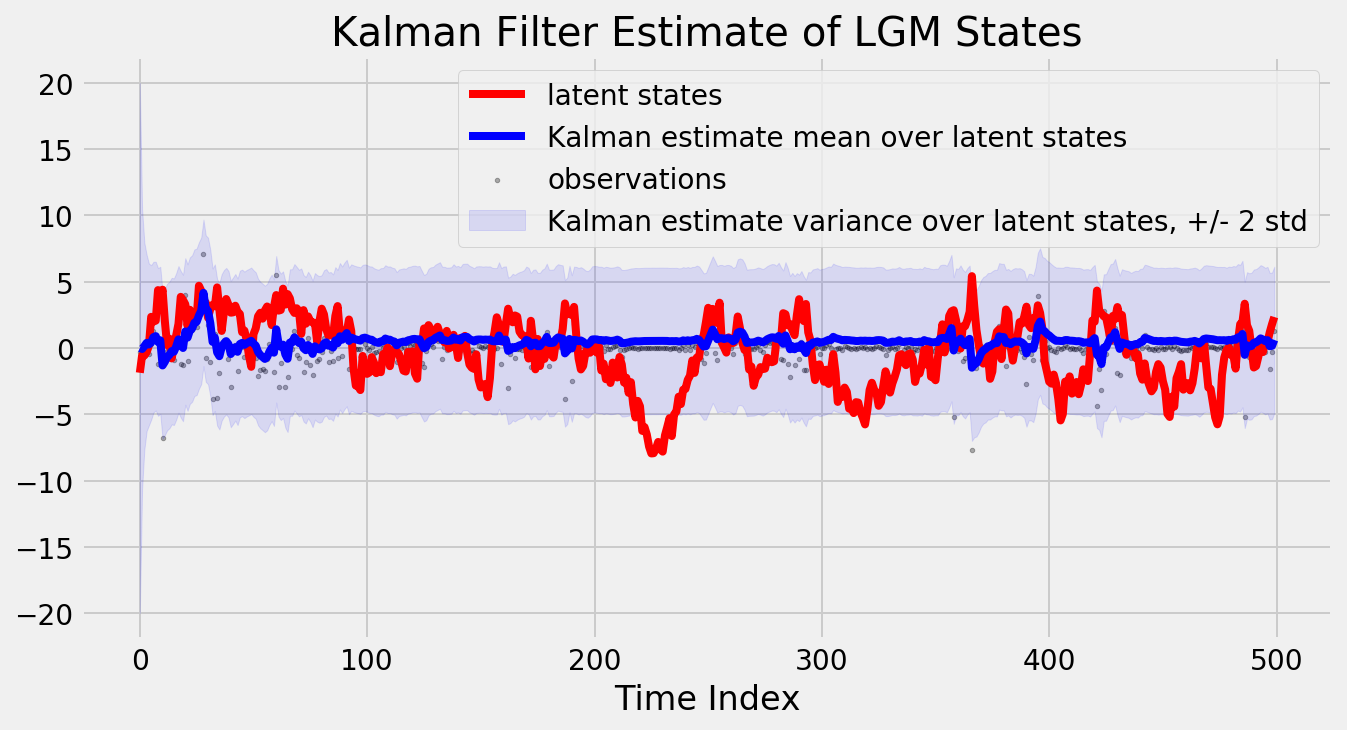

In [138]:
###define the parameters of the Linear Gaussian Model

#parameters for the underlying markov process: x_n+1 = a * x_n + b + c * N(0, 1)
a = 1.01
b = 0.2
c = 1.

#parameters for the observation model: y_n = d * x_n + e + f * N(0, 1)
d = 1.
e = 0.
f = np.sqrt(10)

latent_vars, observations = SVM_simulate(sigma, alpha, beta, sample_x, steps=steps)

###estimate latent states given observations using Kalman filtering
x_mus, x_sigmas = kalman_filter(observations, a, b, c, d, e, f, mu_init=0, sigma_init=10)


def plot_svm_filter(ax):
    ###compare true latent states with estimated latent states from Kalman filtering

    #plot ground truth
    ax.plot(np.arange(steps), latent_vars, 
            color='red', label='latent states')
    ax.scatter(np.arange(len(observations)), observations,
               color='black', s=5., alpha=0.3, label='observations')

    #plot estimated mean of marginal posterior over latent states
    ax.plot(np.arange(steps), x_mus, 
            color='blue', label='Kalman estimate mean over latent states')

    #plot estimated variance of marginal posterior over latent states
    ax.fill_between(np.arange(steps), x_mus + 2 * x_sigmas, x_mus - 2*x_sigmas, 
                    color='blue', alpha=0.1, 
                    label='Kalman estimate variance over latent states, +/- 2 std')

    ax.legend(loc='best')
    ax.set_xlabel('Time Index')
    ax.set_title('Kalman Filter Estimate of LGM States')
    
    return ax

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = plot_svm_filter(ax)
plt.show()

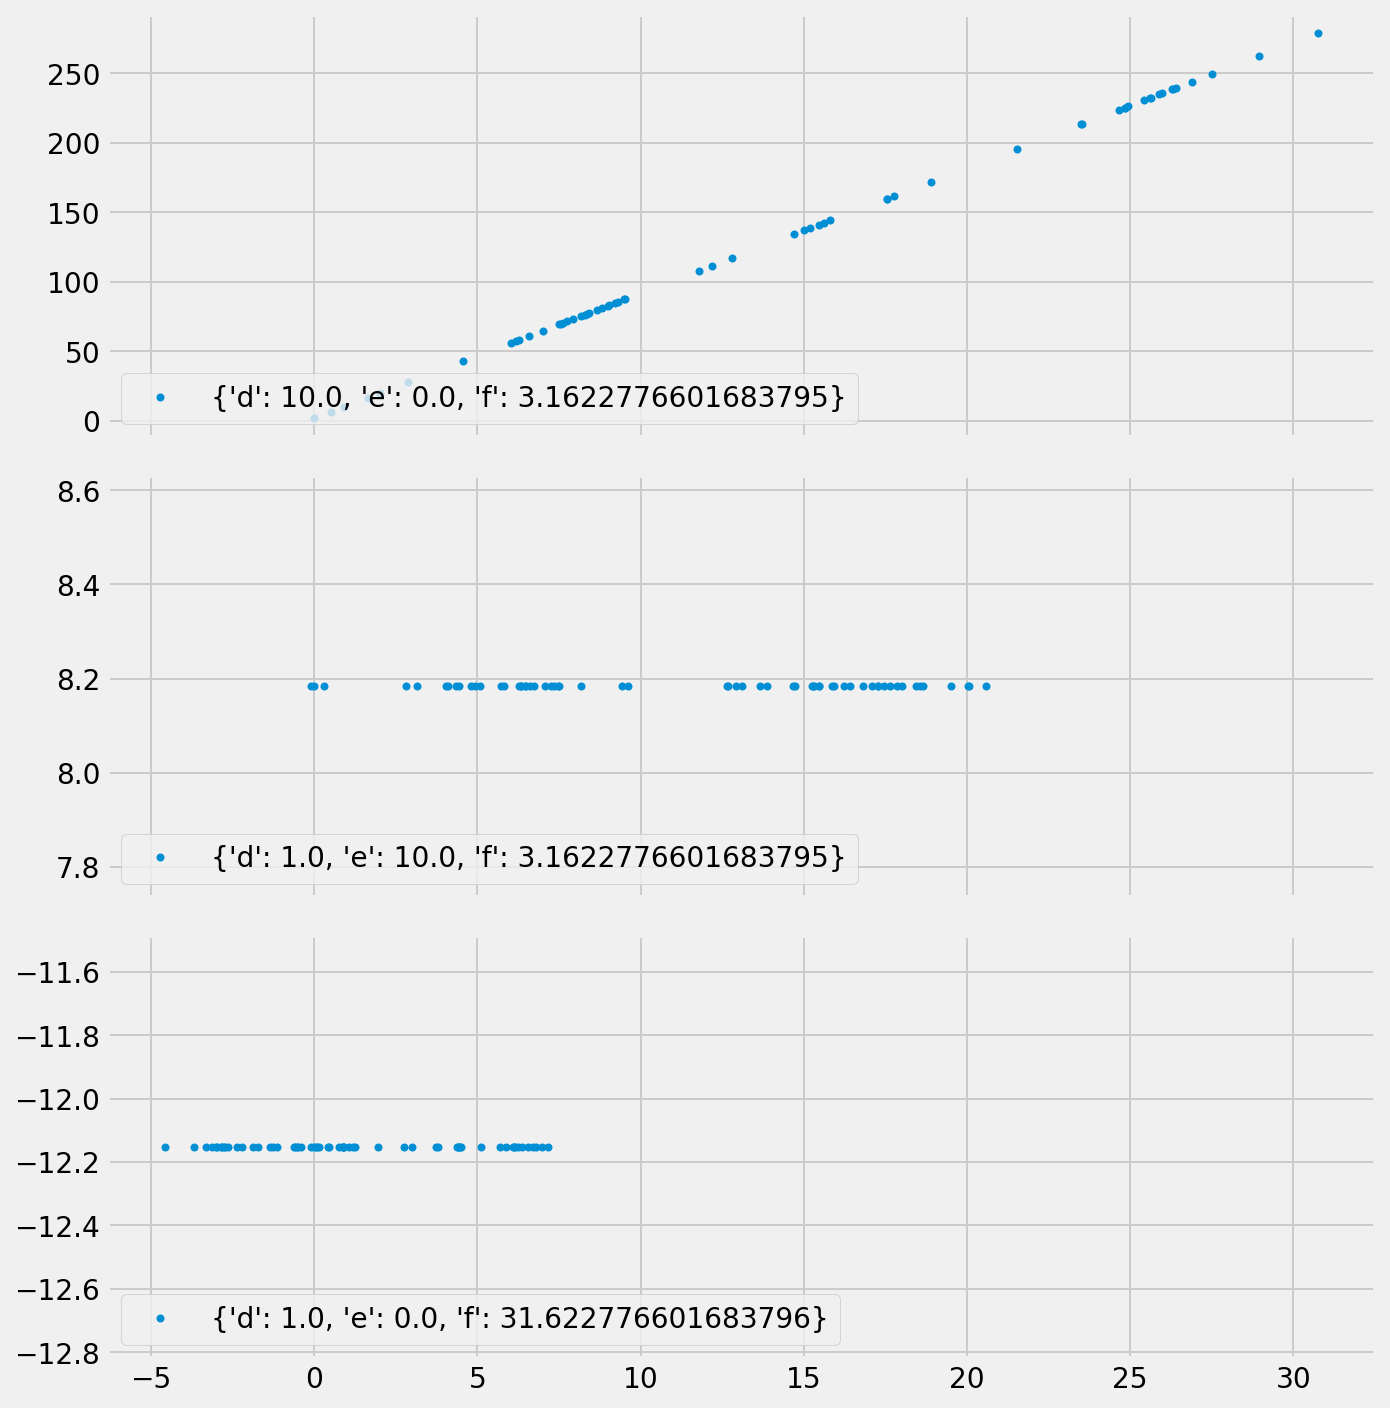

In [144]:
# simulate observation model
def observation_model(X, d, e, f):
    eps = np.random.randn()
    Y = d*X + e + f*eps 
    return np.array(Y)

# plot Y - X
def plot_diff(ax, X, Y, obs_params):
    ax.plot(X, Y - X, '.', label=obs_params)
    ax.legend(loc=3)
    return ax
    

fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

# keep state model fixed
state_params = {
    'a': 1.01,
    'b': 0.2,
    'c': 1.,
}

# large d
obs_params = {
    'd': 10.,
    'e': 0.,
    'f': np.sqrt(10.),
}
X = state_model(X_0=0, N=60, state_params=state_params)
Y = observation_model(X, **obs_params)
plot_diff(axes[0], X, Y, obs_params)

# large e
obs_params = {
    'd': 1.,
    'e': 10.,
    'f': np.sqrt(10.),
}
X = state_model(X_0=0, N=60, state_params=state_params)
Y = observation_model(X, **obs_params)
plot_diff(axes[1], X, Y, obs_params)

# large f
obs_params = {
    'd': 1.,
    'e': 0.,
    'f': 10.*np.sqrt(10.),
}
X = state_model(X_0=0, N=60, state_params=state_params)
Y = observation_model(X, **obs_params)
plot_diff(axes[2], X, Y, obs_params)
    
fig.tight_layout()